In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np

#pre_processing
#
#
#
#
#
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)

df_clean = df_clean_column.dropna(axis = 0)

pmmet_class = np.unique(df_clean['pmmet'])


pmmet_value = [sum(df_clean['pmmet']==pmmet_class[0]),
             sum(df_clean['pmmet']==pmmet_class[1])]

y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values
X.shape
#


(1555, 14)

In [3]:
from imblearn.over_sampling import SMOTE
from collections import Counter
######
oversample = SMOTE()
X,y = oversample.fit_resample(X,y)
######

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
######

from sklearn.decomposition import PCA
fr = PCA(n_components=4)
fr.fit(X_train)
X_test = fr.transform(X_test)
X_train = fr.transform(X_train)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [4]:
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100,200],
    'max_depth' : [2, 4, 8],
    'learning_rate' : [0.001, 0.01, 0.1],
    'subsample' : [0.5,0.8, 1],
    'colsample_bytree' : [0.5, 0.8, 1]    
}

start=datetime.now()
clf = GridSearchCV(xgb.XGBClassifier(random_state=0, objective='binary:logistic',n_jobs=-1),params, cv = 10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))
runtime = datetime.now()-start
print('best param search: '+ str(runtime))

Best params : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
10CV accuracy : 82.53204208512675
best param search: 0:06:12.897675


In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
start = datetime.now()
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
runtime = datetime.now()-start

print('test runtime: '+ str(runtime))
sum(y_test == y_predict)/len(y_test)

test runtime: 0:00:00.010879


0.859375

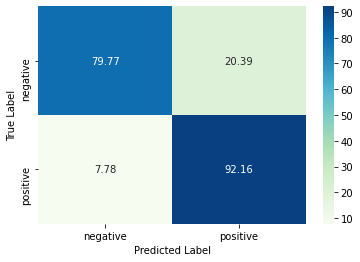

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [7]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.91      0.80      0.85       257
    positive       0.82      0.92      0.87       255

    accuracy                           0.86       512
   macro avg       0.86      0.86      0.86       512
weighted avg       0.87      0.86      0.86       512

